In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8609142173534651521
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9080737575347913529
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 96927744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11705825456033011944
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 161827357660719783
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0816 07:05:30.748323 140481931388672 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 07:05:30.749112 140481931388672 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0816 07:05:30.749741 140481931388672 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0816 07:05:30.757012 140481931388672 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use 

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
#read in the csvs obtained from 03_tags_clustering
chem = pd.read_csv("../data/equation/chemistry_post_eq_tag_id.csv", lineterminator='\n')
physics = pd.read_csv("../data/equation/physics_post_eq_tag_id.csv", lineterminator='\n')
bio = pd.read_csv("../data/equation/biology_post_eq_tag_id.csv", lineterminator='\n')

In [6]:
df = pd.concat([chem, physics, bio], ignore_index=True)
df.head()

,Equation,Label,Cluster_label,Id,Tags
0,\mathrm{NaCl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
1,\mathrm{Cl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
2,\mathrm{Cl^-},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
3,\mathrm{Na},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
4,\mathrm{Na^+},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...


In [7]:
df.rename(columns={"Label": "Source"}, inplace = True)

In [8]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.Id
    post_ids = df.Id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.Id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [9]:
np.random.seed(1)
print('Null Data: ', df.Equation.isnull().sum())
df.dropna(subset=['Equation'], inplace=True)
df = df.drop_duplicates(subset=['Equation', 'Source', 'Cluster_label'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  184
Training rows: 269523
Val rows: 28265
Test rows: 31653


In [10]:
train_df.head()

,Equation,Source,Cluster_label,Id,Tags
0,\mathrm{NaCl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
1,\mathrm{Cl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
2,\mathrm{Cl^-},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
3,\mathrm{Na},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
4,\mathrm{Na^+},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...


In [11]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [12]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.Equation)

# convert string to list of int
train_df['seq'] = train_df.Equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.Equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.Equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.Cluster_label.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['Label'] = train_df.Cluster_label.map(label_map)
val_df['Label'] = val_df.Cluster_label.map(label_map)
test_df['Label'] = test_df.Cluster_label.map(label_map)


/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [13]:
encode_sequence('1234', tokenizer)

[1, 331, 61, 118, 137, 2]

In [14]:
tokenizer['4']

137

In [15]:
len(tokenizer.vocab)

337

In [16]:
label_map

{'chemistry': 0,
 'physics-everything-else': 1,
 'physics-quantum-mechanics': 2,
 'quantum-field-theory': 3,
 'biology': 4}

In [17]:
train_df.sample(10)

,Equation,Source,Cluster_label,Id,Tags,seq,length,Label
654016,W_{A_{12}}=W_{A_{22}},biology,biology,68143,NaN,"[1, 51, 294, 72, 315, 294, 72, 331, 61, 93, 93...",23,4
272610,E_n = \hbar\omega(n + 1/2),physics,physics-everything-else,98952,<homework-and-exercises><statistical-mechanics>,"[1, 193, 294, 197, 302, 308, 302, 152, 209, 12...",28,1
270387,\frac{\vec\mu_1\cdot\vec\mu_2}{R^3}-3\frac{(\v...,physics,physics-quantum-mechanics,95652,<quantum-mechanics><statistical-mechanics><isi...,"[1, 152, 332, 250, 17, 210, 72, 152, 15, 334, ...",96,2
287234,"(-\nabla^2 - E) \psi(x, y) = 0",physics,physics-everything-else,113761,<homework-and-exercises><greens-functions>,"[1, 299, 183, 152, 197, 17, 120, 59, 17, 203, ...",32,1
142026,\pu{800°C},chemistry,chemistry,81481,NaN,"[1, 152, 104, 318, 72, 143, 159, 159, 160, 60,...",12,0
45365,\Delta E \space,chemistry,chemistry,28187,NaN,"[1, 152, 276, 334, 59, 40, 17, 302, 193, 302, ...",18,0
618832,"a_i = (\phi_i,\phi)",physics,quantum-field-theory,463350,<quantum-field-theory><regularization><functio...,"[1, 17, 294, 293, 302, 308, 302, 299, 152, 104...",21,3
211774,a=1,physics,physics-quantum-mechanics,23183,<quantum-mechanics><quantum-information><quant...,"[1, 17, 308, 331, 2]",5,2
374227,k_a=\nabla_au,physics,physics-everything-else,219487,<general-relativity><differential-geometry><ge...,"[1, 85, 294, 17, 308, 152, 197, 17, 120, 59, 1...",15,1
37105,"E_\text{a} = 53\,568.49\ \mathrm{J/mol}",chemistry,chemistry,22158,NaN,"[1, 193, 294, 152, 40, 334, 49, 40, 72, 17, 93...",41,0


In [18]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False, n_class: int = 3):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.n_class = n_class
        self.class_weight =  self.compute_class_weight(self.n_class) if self.weight else np.ones((self.n_class,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.Label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self, n_classes):
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.Label.values))


In [19]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [20]:
def clf_model(tokenizer, emb, n_kernels, kernel_width, n_class):
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(n_class, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [21]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])


# model1: clustersize = 5, batch_size = 1024, emb = 32, n_kernels = 128, kernel_width = 3, epochs = 16

In [22]:
batch_size = 1024
n_class = 5
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True, n_class = n_class)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False, n_class = n_class)

In [23]:
emb = 32
n_kernels = 128
kernel_width = 3

In [24]:
model = clf_model(tokenizer, emb, n_kernels, kernel_width, n_class)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


W0815 19:08:23.104248 140013776791296 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0815 19:08:23.107206 140013776791296 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     10784       input_1[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [25]:
model.save('../result/model/model1_cluster5_epoch16.h5')

In [26]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=16,
    workers=4,
    use_multiprocessing=True
)

W0815 19:08:27.654284 140013776791296 deprecation.py:323] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/16
264/264 [==============================] - 17s 66ms/step - loss: 1.3179 - sparse_categorical_accuracy: 0.3727 - val_loss: 1.3394 - val_sparse_categorical_accuracy: 0.3910
Epoch 2/16
264/264 [==============================] - 14s 53ms/step - loss: 1.2133 - sparse_categorical_accuracy: 0.4478 - val_loss: 1.2420 - val_sparse_categorical_accuracy: 0.4483
Epoch 3/16
264/264 [==============================] - 14s 53ms/step - loss: 1.1768 - sparse_categorical_accuracy: 0.4608 - val_loss: 1.2272 - val_sparse_categorical_accuracy: 0.4472
Epoch 4/16
264/264 [==============================] - 14s 53ms/step - loss: 1.1460 - sparse_categorical_accuracy: 0.4793 - val_loss: 1.2119 - val_sparse_categorical_accuracy: 0.4645
Epoch 5/16
264/264 [==============================] - 14s 53ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.4899 - val_loss: 1.1323 - val_sparse_categorical_accuracy: 0.5134
Epoch 6/16
264/264 [==============================] - 14s 53ms/step - loss: 1.0834 - spars

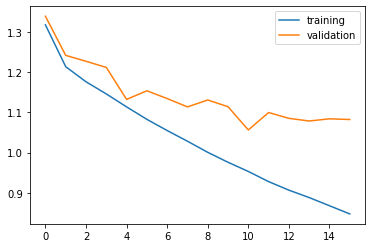

In [27]:
%matplotlib inline
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


# save loss data

In [28]:
import pickle

In [29]:
with open('../result/loss/model1_cluster5_epoch16', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [30]:
file = open('../result/loss/model1_cluster5_epoch16', 'rb')
data = pickle.load(file)

# Evaluation

## evaluation tools

In [38]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png')
    return ax

In [39]:
def predict_on_df(model, df, batch_size, n_class):
    dg = DataGenerator(df, batch_size=batch_size, shuffle=False, weight = False, n_class = n_class)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['Label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['Equation', 'pred_label', 'Cluster_label', 'pred_index', 'Label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [40]:
batch_size = 1024
n_class = 5
predictions = predict_on_df(model, val_df, batch_size, n_class)

In [44]:
%matplotlib inline

Confusion matrix, without normalization
[[5161  689  438  442  713]
 [ 996 6541 2077 3201 1425]
 [ 100  547 2170  760  373]
 [  49  282  398 1287  166]
 [  83   60   32   30  245]]


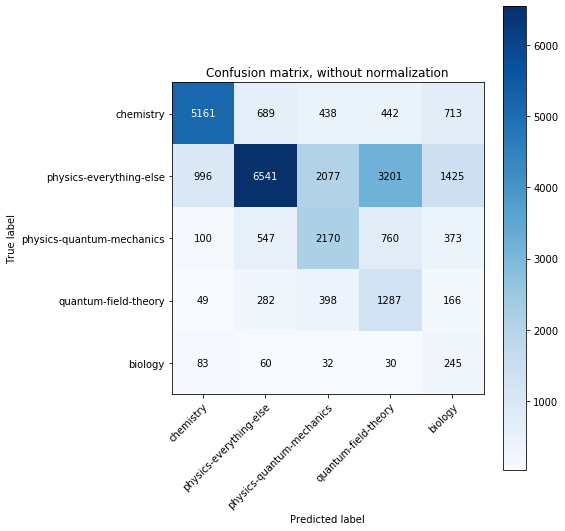

In [45]:
name = "model1_cluster5_epoch128_1"
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name)


Normalized confusion matrix
[[0.6934032  0.0925702  0.05884724 0.05938466 0.09579471]
 [0.06994382 0.45933989 0.14585674 0.22478933 0.10007022]
 [0.02531646 0.13848101 0.54936709 0.19240506 0.09443038]
 [0.02245646 0.12923923 0.18240147 0.58982585 0.07607699]
 [0.18444444 0.13333333 0.07111111 0.06666667 0.54444444]]


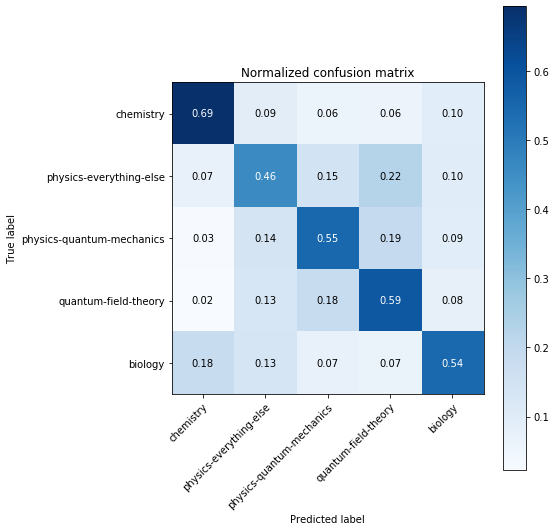

In [46]:
name = "model1_cluster5_epoch128_2"
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize=True)


In [47]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'yhat': [[0.38748618960380554,
   0.21728625893592834,
   0.33957773447036743,
   0.05234651640057564,
   0.0033032973296940327]],
 'pred_index': 0,
 'label': 'chemistry'}

In [48]:
display_top_losses(predictions, 20)

,Equation,pred_label,Cluster_label,pred_index,Label,pred_conf
654596,\ce{R1-S-S-R2 + R3-SH &lt;=&gt; R1-S-S-R3 + R2...,chemistry,biology,0,4,0.995662
402378,z\left( {m + 1} \right) = f\left[ {z\left( m \...,biology,physics-everything-else,4,1,0.993719
654595,\ce{HOCH2CH2-S-S-CH2CH2OH + HS-{Protein} &lt;=...,chemistry,biology,0,4,0.993349
91774,\hspace{13 mm}=4.0\times10^{2},biology,chemistry,4,0,0.993241
376865,N\left(\frac{2x}{q}\right)^2= 1\;\; \text{or} ...,biology,physics-everything-else,4,1,0.992067
346857,[t] = [K][V^a][A^b][C^c],chemistry,physics-everything-else,0,1,0.991990
471553,Z_{\mathrm{PBC}} = \left( e^{\beta J} + 1 \rig...,chemistry,physics-everything-else,0,1,0.991033
204922,4NE_0p(1-p),biology,physics-everything-else,4,1,0.990241
334546,^\circ\mathrm{C}^2,chemistry,physics-everything-else,0,1,0.987937
643676,V_{W/G},biology,physics-everything-else,4,1,0.987759
